# 多目标优化

## 超参数调优

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree 
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import randint, uniform

data = pd.read_excel('0.dataset.xlsx', sheet_name='Sheet1')
X = data.iloc[:, :14]
y = data.iloc[:, 14].values.reshape(-1, 1) # 第12列为剪力差，13列为位移差
print(X.head())
print(y[:5])
# 数据缩放
# 对特征进行缩放
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 对目标变量进行缩放
scaler_y = StandardScaler() # 注意，如果要对y进行缩放，应该重新定义一个缩放器StandardScaler()，不然会使用X的统计特征进行缩放。
y_scaled = scaler_y.fit_transform(y)  # 重塑 y 以避免维度问题
# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 超参数调优
regressor = xgb.XGBRegressor()

param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0, 1),
    'subsample': uniform(0, 1),
    'min_child_weight': randint(1, 10)
}

random_search = RandomizedSearchCV(regressor, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# 应用最佳参数
best_params = random_search.best_params_
regr_best = xgb.XGBRegressor(**best_params)
regr_best.fit(X_train, y_train)
Pred_train = regr_best.predict(X_train)
Pred_test = regr_best.predict(X_test)

# 输出最佳参数
print("Best Parameters: ", random_search.best_params_)

# 打印性能指标
print('xgb')
print("Training R2: {:.2f}".format(r2_score(y_train, Pred_train)))
print("Testing R2: {:.2f}".format(r2_score(y_test, Pred_test)))

   H1  H2   alpha_p1   alpha_p2     gama1     gama2            Ept   beta_p1  \
0   8  16   7.647204  11.345510  0.526668  0.639862  206818.870193  1.430492   
1   8  16  15.124403   7.855056  0.319854  0.600985  212426.927337  1.057850   
2   8  16   7.221489  15.232760  0.725733  0.410698  209785.551707  0.816532   
3   8  16  10.113507   6.698760  0.678859  0.981958  224250.000000  0.823410   
4   8  16   7.785689  17.020106  0.571246  0.325871  189384.461982  1.148872   

    beta_p2     ED筋屈服强度          ED筋弹模         fc       阻尼比      质量系数  
0  0.749161  427.837883  198234.996611  26.921020  0.021231  1.046644  
1  1.413659  340.000000  203250.569181  34.230016  0.058234  0.999516  
2  1.476657  439.960995  190280.160748  36.871813  0.034745  0.972090  
3  0.562086  450.668030  182778.173083  36.045848  0.066653  0.992585  
4  1.390872  374.950962  216144.010062  30.573031  0.030706  1.101129  
[[1546.06]
 [1318.02]
 [ 650.38]
 [1472.33]
 [ 843.08]]
Best Parameters:  {'colsample_b

## 构建XGBoost代理模型

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
from scipy.stats import randint, uniform

# 加载数据
data = pd.read_excel('0.dataset.xlsx', sheet_name='Sheet1')
X = data.iloc[:, :14]
delta_V = data.iloc[:, 14].values.reshape(-1, 1) # 程序需要二维数组，所以用reshape进行转换
delta_D = data.iloc[:, 15].values.reshape(-1, 1)


print(X.head())
print(delta_V[:5])
print(delta_D[:5])

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train_delta_V, y_test_delta_V = train_test_split(X, delta_V, test_size=0.2, random_state=42)
X_train, X_test, y_train_delta_D, y_test_delta_D = train_test_split(X, delta_D, test_size=0.2, random_state=42)

# 构建XGBoost回归模型（超参数根据上一步超参数调优获得）
xgb_model_delta_V = xgb.XGBRegressor(colsample_bytree= 0.9959312420303291, learning_rate= 0.02620263485643151, max_depth= 5, min_child_weight= 7, n_estimators= 832, subsample= 0.3509150125520787)
xgb_model_delta_D = xgb.XGBRegressor(colsample_bytree= 0.9959312420303291, learning_rate= 0.02620263485643151, max_depth= 5, min_child_weight= 7, n_estimators= 832, subsample= 0.3509150125520787)

# 拟合模型
xgb_model_delta_V.fit(X_train, y_train_delta_V)
xgb_model_delta_D.fit(X_train, y_train_delta_D)

# 预测
y_pred_delta_V = xgb_model_delta_V.predict(X_test)
y_pred_delta_D = xgb_model_delta_D.predict(X_test)

# 计算评价指标
r2_delta_V = r2_score(y_test_delta_V, y_pred_delta_V)
r2_delta_D = r2_score(y_test_delta_D, y_pred_delta_D)

# 输出结果
print(f"Evaluation for delta_V: R²= {r2_delta_V:.2f}")
print(f"Evaluation for delta_D: R²= {r2_delta_D:.2f}")

# 输出模型
xgb_model_delta_V.save_model('xgb_model_delta_V.model')
xgb_model_delta_D.save_model('xgb_model_delta_D.model')

   H1  H2   alpha_p1   alpha_p2     gama1     gama2            Ept   beta_p1  \
0   8  16   7.647204  11.345510  0.526668  0.639862  206818.870193  1.430492   
1   8  16  15.124403   7.855056  0.319854  0.600985  212426.927337  1.057850   
2   8  16   7.221489  15.232760  0.725733  0.410698  209785.551707  0.816532   
3   8  16  10.113507   6.698760  0.678859  0.981958  224250.000000  0.823410   
4   8  16   7.785689  17.020106  0.571246  0.325871  189384.461982  1.148872   

    beta_p2     ED筋屈服强度          ED筋弹模         fc       阻尼比      质量系数  
0  0.749161  427.837883  198234.996611  26.921020  0.021231  1.046644  
1  1.413659  340.000000  203250.569181  34.230016  0.058234  0.999516  
2  1.476657  439.960995  190280.160748  36.871813  0.034745  0.972090  
3  0.562086  450.668030  182778.173083  36.045848  0.066653  0.992585  
4  1.390872  374.950962  216144.010062  30.573031  0.030706  1.101129  
[[1546.06]
 [1318.02]
 [ 650.38]
 [1472.33]
 [ 843.08]]
[[0.06257369]
 [0.07243095]
 [0

c:\Users\26689\anaconda3\envs\openseespy\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


### 加载XGBoost模型

In [3]:
import xgboost as xgb
# 加载模型
xgb_model_delta_V = xgb.XGBRegressor()
xgb_model_delta_V.load_model('xgb_model_delta_V.model')
xgb_model_delta_D = xgb.XGBRegressor()
xgb_model_delta_D.load_model('xgb_model_delta_D.model')


## NSGA

### 计算Pareto front

#### 全部变量

c:\Users\26689\anaconda3\envs\openseespy\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\26689\anaconda3\envs\openseespy\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Individual 1: [np.float64(10.618101782710436), np.float64(19.260714596148745), np.float64(0.7855951534491241), np.float64(0.6789267873576292), np.float64(189552.7365686231), np.float64(0.5580836121681995), np.float64(1.366176145774935), np.float64(388.8267630737579), np.float64(216151.65840133067), np.float64(34.33229805453023), np.float64(0.0391315701758131), np.float64(1.060909498032426)]
Individual 2: [np.float64(7.7510676478015075), np.float64(9.563633644393066), np.float64(0.6198051453057902), np.float64(0.5455560149136927), np.float64(204822.85575260373), np.float64(0.7912291401980419), np.float64(1.1118528947223796), np.float64(381.37807693440914), np.float64(192476.05443447357), np.float64(28.65509292540941), np.float64(0.03713156298844686), np.float64(1.0808540663048167)]
Individual 3: [np.float64(13.886218532930638), np.float64(5.696756190799966), np.float64(0.6860358815211507), np.float64(0.33641929894983325), np.float64(205952.96422572393), np.float64(0.5650515929852795), n

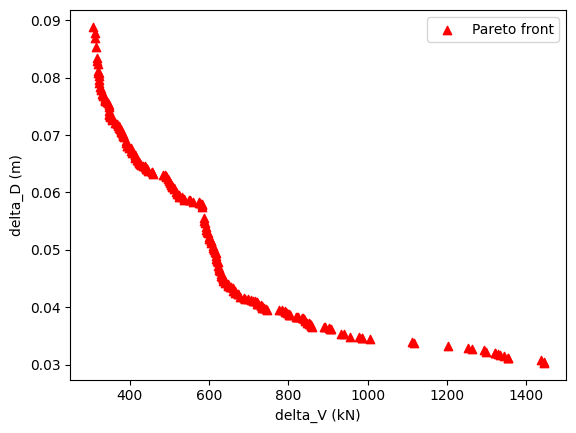

In [12]:
### 第一步：导入必要的库
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from deap import base, creator, tools, algorithms
import random
from scipy.stats import uniform ,norm, lognorm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time  # 导入时间模块用于计时

# 设置随机数种子,为了保证多次运行的结果一致
random.seed(42)
np.random.seed(42)

### 第三步：定义预测函数（调用机器学习模型预测剪力差和位移差）
def predict_objectives(xgb_model_delta_V, xgb_model_delta_D,    alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass): 
    H1,H2=8,16
    X = np.array([[H1,H2,alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass]])
    delta_V = xgb_model_delta_V.predict(X)[0]
    delta_D = xgb_model_delta_D.predict(X)[0]
    return delta_V, delta_D

### 第四步：定义个体和种群
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0)) # weights的正号表示最大化，负号表示最小化
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()


def bounded_normal(loc, scale, lower, upper):
    while True:
        value = norm.rvs(loc=loc, scale=scale)
        if lower <= value <= upper:
            return value

def bounded_lognorm(s, scale, lower, upper):
    while True:
        value = lognorm.rvs(s=s, scale=scale)
        if lower <= value <= upper:
            return value
mean = 195000
std_dev = 19500

mean1 = 400
std_dev1 = 40

mean2 = 2.00E+05
std_dev2 = 1.00E+04
# 计算对数正态分布的mu和sigma
mu = np.log(mean / np.sqrt(1 + (std_dev / mean)**2))
sigma = np.sqrt(np.log(1 + (std_dev / mean)**2))

mu1 = np.log(mean1 / np.sqrt(1 + (std_dev1 / mean1)**2))
sigma1 = np.sqrt(np.log(1 + (std_dev1 / mean1)**2))

mu2 = np.log(mean2 / np.sqrt(1 + (std_dev2 / mean2)**2))
sigma2 = np.sqrt(np.log(1 + (std_dev2 / mean2)**2))

toolbox.register("attr_gama_1", uniform.rvs, loc=0.2, scale=1-0.2)
toolbox.register("attr_gama_2", uniform.rvs, loc=0.2, scale=1-0.2)
toolbox.register("attr_alpha_1", uniform.rvs, loc=5, scale=20-5)
toolbox.register("attr_alpha_2", uniform.rvs, loc=5, scale=20-5)
toolbox.register("attr_beta_d1", uniform.rvs, loc=0.5, scale=1.5-0.5)
toolbox.register("attr_beta_d2", uniform.rvs, loc=0.5, scale=1.5-0.5)
toolbox.register("attr_damping", bounded_normal, loc=0.045, scale=0.0125, lower=0.02, upper=0.07)
toolbox.register("attr_mass", uniform.rvs, loc=1.05, scale=0.06)
toolbox.register("attr_Ep", bounded_lognorm, s=sigma, scale=np.exp(mu), lower=165750, upper=224250)
toolbox.register("attr_Fd", bounded_lognorm, s=sigma1, scale=np.exp(mu1), lower=340, upper=460)
toolbox.register("attr_Ed", bounded_lognorm, s=sigma2, scale=np.exp(mu2), lower=1.80E+05, upper=2.20E+05)
toolbox.register("attr_Fc", bounded_normal, loc=31.37, scale=3.86, lower=22.75, upper=39.09)
# Structure initializers
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_alpha_1, toolbox.attr_alpha_2, toolbox.attr_gama_1, toolbox.attr_gama_2,toolbox.attr_Ep,toolbox.attr_beta_d1, toolbox.attr_beta_d2,toolbox.attr_Fd,toolbox.attr_Ed,toolbox.attr_Fc, toolbox.attr_damping,toolbox.attr_mass), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### 第五步：定义评估函数
evaluate_count = 0  # 评估函数调用次数
evaluate_time = 0  # 评估函数总运行时间

def evaluate(individual):
    global evaluate_count, evaluate_time
    start_time = time.time()  # 开始计时
    evaluate_count += 1  # 调用次数加1
    alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass = individual
    delta_V, delta_D = predict_objectives(xgb_model_delta_V, xgb_model_delta_D,alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass)
    # 目标函数
    obj1 = abs(delta_V)
    obj2 = abs(delta_D)
    end_time = time.time()  # 结束计时
    evaluate_time += (end_time - start_time)  # 累加评估函数运行时间
    return obj1, obj2

### 第六步：定义遗传算子
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
# mutPolynomialBounded 是一种适用于实值变量的变异方法，在边界内对个体的基因进行小幅度随机变化。eta（分布指数）控制变异分布的程度。indpb 表示独立变异概率（individual probability）。
toolbox.register("mutate", tools.mutPolynomialBounded, eta=5, low=[5, 5, 0.2, 0.2, 165750, 0.5, 0.5, 340, 1.80E+05, 22.75, 0.02, 1.05], 
                 up=[20, 20, 1, 1, 224250, 1.5, 1.5, 460, 2.20E+05, 39.09, 0.07, 1.11], indpb=0.5)

toolbox.register("select", tools.selNSGA2)


### 第七步：执行NSGA-II算法
# 初始化种群
pop = toolbox.population(n=300)  # 种群大小
for i, individual in enumerate(pop[:10]):  # 只取前10个个体
    print(f"Individual {i+1}: {individual}")
NGEN = 100  # 算法的最大迭代次数
CXPB = 0.3  # 交叉概率
MUTPB = 0.7  # 变异概率
# 算法总运行时间
start_time = time.time()  # 开始计时
# 运行算法
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=len(pop), lambda_=len(pop), cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, verbose=True)
end_time = time.time()  # 结束计时
total_time = end_time - start_time  # 算法总运行时间

# 使用拥挤距离排序，鼓励算法寻找分散的解
fronts = tools.sortNondominated(pop, len(pop), first_front_only=True)
# 获取Pareto最优解
pareto_front = [ind.fitness.values for ind in fronts[0]]
pareto_front = np.array(pareto_front)
# 去除Pareto前沿解中的重合点
pareto_front = np.unique(pareto_front, axis=0)

print(f"去重后的Pareto前沿解个数: {pareto_front.shape[0]}")


# 打印统计信息
print(f"评估函数调用次数：{evaluate_count}")
print(f"评估函数平均运行时间：{evaluate_time / evaluate_count:.6f} 秒")
print(f"NSGA-II算法总运行时间: {total_time:.1f} 秒")

### 第八步：可视化Pareto前沿和初始种群
import matplotlib.pyplot as plt#导入模块
fig, ax = plt.subplots(figsize=(6.4, 4.8))
plt.scatter(pareto_front[:,0], pareto_front[:,1], c="r", marker="^", label="Pareto front")
plt.xlabel("delta_V (kN)")
plt.ylabel("delta_D (m)")
plt.legend()
plt.show()
# # 输出到Excel
df = pd.DataFrame(pareto_front, columns=['delta_V', 'delta_D'])  # 列名可以根据实际情况调整
with pd.ExcelWriter("C:\\Users\\26689\\Desktop\\nsga2.xlsx", mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name='Pareto_Pop300_Ngen300', index=False)



### 初始种群

In [13]:
# 初始种群不考虑惩罚项
### 第五步：定义评估函数
def evaluate(individual):
    global evaluate_count, evaluate_time
    start_time = time.time()  # 开始计时
    evaluate_count += 1  # 调用次数加1
    alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass = individual
    delta_V, delta_D = predict_objectives(xgb_model_delta_V, xgb_model_delta_D,alpha_1,alpha_2, gama_1,gama_2, Ep,beta_d1,beta_d2,Fd,Ed,Fc,damping,mass)
    # 目标函数
    obj1 = abs(delta_V)
    obj2 = abs(delta_D)
    end_time = time.time()  # 结束计时
    evaluate_time += (end_time - start_time)  # 累加评估函数运行时间
    return obj1, obj2


### 第六步：定义遗传算子
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=100, indpb=0.5)
toolbox.register("select", tools.selNSGA2)


### 第七步：执行NSGA-II算法
# 初始化种群
pop = toolbox.population(n=400)  # 种群大小
# 计算初始种群的目标值
initial_pop_objectives = [toolbox.evaluate(ind) for ind in pop]
initial_pop_objectives = np.array(initial_pop_objectives)

# # # 输出到Excel
df = pd.DataFrame(initial_pop_objectives, columns=['delta_V', 'delta_D'])  # 列名可以根据实际情况调整
with pd.ExcelWriter("C:\\Users\\26689\\Desktop\\nsga2.xlsx", mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name='initial_pop_N100', index=False)

### 出图

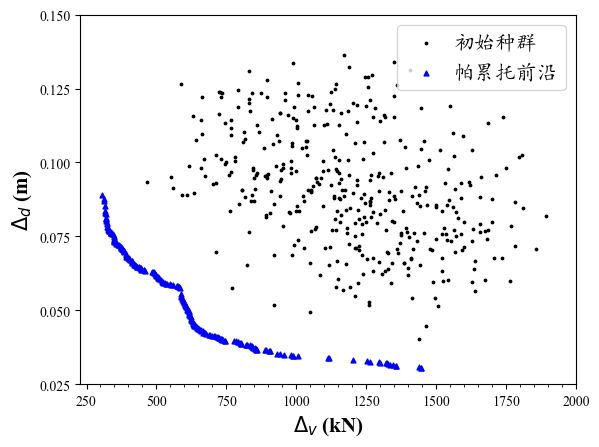

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
import seaborn as sns  # 导入seaborn库

# 指定楷体字体路径
font_path = 'C:/Windows/Fonts/simkai.ttf'  # 修改为你的楷体字体路径
font_prop = FontProperties(fname=font_path, size=15)
font_path_roman = 'C:/Windows/Fonts/timesbd.ttf' 
font_roman = FontProperties(fname=font_path_roman, size=15)  


# 读取 Excel 文件中的 'Sheet2' 工作表
file_path = r"C:\Users\26689\Desktop\nsga2.xlsx"
# 读取数据到 DataFrame
df = pd.read_excel(file_path, sheet_name='Pareto_Pop300_Ngen300')
# 将 DataFrame 转换为 numpy 数组
pareto_front = df.to_numpy()
# 读取数据到 DataFrame
df = pd.read_excel(file_path, sheet_name='initial_pop_N100')
# 将 DataFrame 转换为 numpy 数组
initial_pop_objectives = df.to_numpy()

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(6.4, 4.8))

# 绘制初始种群
plt.scatter(initial_pop_objectives[:, 0], initial_pop_objectives[:, 1], c="black", marker="o", s=3, label="初始种群")
# 绘制 Pareto 前沿
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c="b", marker="^", s=12, label="帕累托前沿")

# 设置刻度字体
plt.minorticks_on()  # 开启小刻度
ax.yaxis.set_minor_locator(plt.NullLocator())  # 仅关闭纵轴的小刻度
from matplotlib.ticker import MultipleLocator
ax.yaxis.set_major_locator(MultipleLocator(0.025))
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  # 刻度标签使用 Times New Roman

# 设置坐标轴标签和标题
plt.xlabel(r"$\Delta_{v}$ (kN)", fontproperties=font_roman)
plt.ylabel(r"$\Delta_{d}$ (m)", fontproperties=font_roman)
plt.legend(loc='upper right', handletextpad=0.3, prop=font_prop) 

# 设置坐标轴范围
ax.set_xticks(np.arange(250, 2001, 250))  # 从 250 开始，到 1900 结束，每隔 250 一个刻度
ax.set_ylim([0.025, 0.15])
plt.savefig("NSGA.svg", format="svg", dpi=300) 
# 显示图形
plt.show()

## 多目标决策

In [15]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from math import log
# 说明：必须先运行NSGA，才能找到Pareto 解集中最优解对应的原始个体

# 读取 Excel 文件中的 'Sheet2' 工作表
file_path = r"C:\Users\26689\Desktop\nsga2.xlsx"
sheet_name = 'Pareto_Pop300_Ngen300'

# 读取数据到 DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# 将 DataFrame 转换为 numpy 数组
pareto_front = df.to_numpy()

# 构建决策矩阵
decision_matrix = pareto_front.copy()

# 标准化决策矩阵
min_values = decision_matrix.min(axis=0)
max_values = decision_matrix.max(axis=0)
standardized_matrix = (max_values - decision_matrix) / (max_values - min_values)

# 计算熵值
entropy_values = []
for col in standardized_matrix.T:
    probabilities = col / col.sum()
    entropy_values.append(entropy(probabilities, base=2))

# 计算熵权
num_criteria = len(entropy_values)
weights = [(1 - e) / (num_criteria - sum(entropy_values)) for e in entropy_values]

# 加权标准化决策矩阵
weighted_matrix = standardized_matrix * weights

# 确定正负理想解
positive_ideal_solution = weighted_matrix.min(axis=0)
negative_ideal_solution = weighted_matrix.max(axis=0)

# 计算到正负理想解的距离
distances_to_pos_ideal = np.sqrt(((weighted_matrix - positive_ideal_solution) ** 2).sum(axis=1))
distances_to_neg_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

# 计算相对接近度
relative_closeness = distances_to_neg_ideal / (distances_to_pos_ideal + distances_to_neg_ideal)

# 选择最优解
best_solution_index = relative_closeness.argmax()
best_solution = pareto_front[best_solution_index]

print("Pareto最优解（剪力差，位移差）:", best_solution)

# 找到 Pareto 解集中最优解对应的原始个体
best_individual = None
for individual in fronts[0]:
    if np.allclose(individual.fitness.values, best_solution):
        best_individual = individual
        break

# 输出最优解的设计参数
print("熵值 =",entropy_values)
print("熵权 =",weights)
print("Optimal design parameters:")
print("最佳参数:", best_individual)

Pareto最优解（剪力差，位移差）: [1.44424976e+03 3.04928515e-02]
熵值 = [np.float64(7.694390105992394), np.float64(7.623590065993403)]
熵权 = [np.float64(0.5026580622243273), np.float64(0.4973419377756727)]
Optimal design parameters:
最佳参数: [np.float64(19.101683984942063), np.float64(17.4028784145913), np.float64(0.3191845970002577), np.float64(0.985223802525291), np.float64(207896.2492579367), np.float64(1.4862688054141078), np.float64(1.4847263289277244), np.float64(427.12992321329074), np.float64(198061.73257244827), np.float64(24.89244222818696), np.float64(0.06780790318348644), np.float64(1.0780211402602289)]


#### 出图

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
C:\Users\26689\AppData\Local\Temp\ipykernel_48572\3267018603.py:37: SyntaxWarning: invalid escape sequence '\D'
  ax.set_xlabel('$\Delta_{v}$ (kN)', labelpad=0, fontdict=font1)
C:\Users\26689\AppData\Local\Temp\ipykernel_48572\3267018603.py:38: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta_{d}$ (m)', labelpad=0, fontdict=font1)
C:\Users\26689\AppData\Local\Temp\ipykernel_48572\3267018603.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


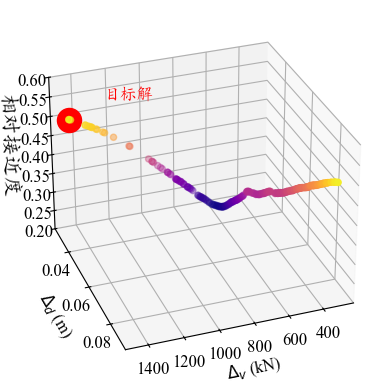

In [16]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import MultipleLocator
from matplotlib.font_manager import FontProperties

# 使用内置的字体近似 Times New Roman
font_path = 'C:/Windows/Fonts/simkai.ttf'  # 修改为你的楷体字体路径
font_prop = FontProperties(fname=font_path, size=15)
font_path_roman = 'C:/Windows/Fonts/timesbd.ttf' 
font_roman = FontProperties(fname=font_path_roman, size=15)  

# 创建三维图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
sc = ax.scatter(pareto_front[:, 0], pareto_front[:, 1], relative_closeness, 
                c=relative_closeness, cmap='plasma')

# 找到 'relative_closeness' 最大的点
max_index = np.argmax(relative_closeness)
max_point = pareto_front[max_index]
max_closeness = relative_closeness[max_index]

# 绘制最大点
ax.scatter(max_point[0], max_point[1], max_closeness, 
           c='red', s=300, edgecolor='r', label='目标解') 

# 在最大点旁边添加文本标注
ax.text(max_point[0]-500, max_point[1], max_closeness+0.01, '目标解',
        color='red', fontsize=12, ha='right', va='bottom', fontproperties=font_prop)

# 设置坐标轴标签
font1 = {'family' : 'Times New Roman', 'weight' : 'normal', 'size' : 12}
ax.set_xlabel('$\Delta_{v}$ (kN)', labelpad=0, fontdict=font1)
ax.set_ylabel('$\Delta_{d}$ (m)', labelpad=0, fontdict=font1)
ax.set_zlabel('相对接近度', labelpad=0, fontproperties=font_prop)
ax.zaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.set_zlim([0.2, 0.6])

# 设置刻度值字体
labels = ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()
[label.set_fontname('Times New Roman') for label in labels]
ax.tick_params(axis='x', direction='in', which='both', bottom=True, top=False, 
               labelbottom=True, labelsize=12, pad=0)  # 设置x轴刻度
plt.tick_params(axis='y', direction='in', which='both', bottom=True, top=False, 
                labelbottom=True, labelsize=12, pad=0)  # 设置y轴刻度
plt.tick_params(axis='z', direction='in', which='both', bottom=True, top=False, 
                labelbottom=True, labelsize=12, pad=0)  # 设置z轴刻度
ax.view_init(elev=30, azim=70)  # 调整仰角和方位角

# 显示图形
plt.tight_layout()
plt.savefig('相对接近度.svg', format="svg", dpi=300)
plt.show()
